# Head Pose Estimation using OpenCV and dlib

In this notebook, we try to estimate the pose of a human head in a photo by using OpenCV and dlib.  
  
In many applications, we need to know how the head is tilted with respect to a camera.   
In a virtual reality application, for example, one can use the pose of the head to render the right view of the scene.  
In a driver assistance system, a camera looking at a driver’s face in a vehicle can use head pose estimation to see if the driver is paying attention to the road.   
One can use head pose based gestures to control a hands-free application / game.   
![1](image/1.png)

## What is pose estimation ?

In computer vision, the pose of an object refers to its relative orientation and position with respect to a camera.   
We can change the pose by either moving the object with respect to the camera, or the camera with respect to the object.

The pose estimation problem described in this tutorial is often referred to as **Perspective-n-Point** problem or PNP in computer vision jargon.   
As we shall see in the following sections in more detail, in this problem the goal is to find the pose of an object when we have a calibrated camera, and we know the locations of **n** 3D points on the object and the corresponding 2D projections in the image.

## How to mathematically represent camera motion ?

A 3D rigid object has only two kinds of motions with respect to a camera.

1. **Translation** : Moving the camera from its current 3D location (X, Y, Z) to a new 3D location (X', Y', Z') is called translation. As you can see translation has 3 degrees of freedom — you can move in the X, Y or Z direction. Translation is represented by a vector \mathbf{t} which is equal to ( X' - X, Y' - Y, Z' - Z ).
  
2. **Rotation** : You can also rotate the camera about the X, Y and Z axes. A rotation, therefore, also has three degrees of freedom. There are many ways of representing rotation. You can represent it using [Euler angles](https://en.wikipedia.org/wiki/Euler_angles) ( roll, pitch and yaw ), a 3\times3 [rotation matrix](https://en.wikipedia.org/wiki/Rotation_matrix), or a [direction of rotation (i.e. axis ) and angle](https://en.wikipedia.org/wiki/Axis%E2%80%93angle_representation).  
  
So, estimating the pose of a 3D object means finding 6 numbers — three for translation and three for rotation.

## What do we need for pose estimation ?

![2](image/2.jpg)

To calculate the 3D pose of an object in an image, we need the following information

1. **2D coordinates of a few points** : We need the 2D (x,y) locations of a few points in the image. In the case of a face, we could choose the corners of the eyes, the tip of the nose, corners of the mouth etc. Dlib’s ***facial landmark detector***  provides us with many points to choose from. In this tutorial, we will use the tip of the nose, the chin, the left corner of the left eye, the right corner of the right eye, the left corner of the mouth, and the right corner of the mouth.  
  
2. **3D locations of the same points** : We also need the 3D location of the 2D feature points. You might be thinking that you need a 3D model of the person in the photo to get the 3D locations. Ideally yes, but in practice, you don’t. A generic 3D model will suffice. Where do you get a 3D model of a head from ? Well, you really don’t need a full 3D model. You just need the 3D locations of a few points in some arbitrary reference frame. In this tutorial, we are going to use the following 3D points.  
---Tip of the nose : ( 0.0, 0.0, 0.0)  
---Chin : ( 0.0, -330.0, -65.0)  
---Left corner of the left eye : (-225.0f, 170.0f, -135.0)  
---Right corner of the right eye : ( 225.0, 170.0, -135.0)  
---Left corner of the mouth : (-150.0, -150.0, -125.0)  
---Right corner of the mouth : (150.0, -150.0, -125.0)  
Note that the above points are in some arbitrary reference frame / coordinate system. This is called the **World Coordinates** ( a.k.a Model Coordinates in OpenCV docs ) .  
  
3. **Intrinsic parameters of the camera**. As mentioned before, in this problem the camera is assumed to be calibrated. In other words, you need to know the focal length of the camera, the optical center in the image and the radial distortion parameters. So you need to [calibrate your camera](https://docs.opencv.org/2.4/doc/tutorials/calib3d/camera_calibration/camera_calibration.html). Of course, for the lazy dudes and dudettes among us, this is too much work. Can I supply a hack ? Of course, I can! We are already in approximation land by not using an accurate 3D model. We can approximate the optical center by the center of the image, [approximate the focal length](https://www.learnopencv.com/approximate-focal-length-for-webcams-and-cell-phone-cameras/) by the width of the image in pixels and assume that radial distortion does not exist.

## How do pose estimation algorithms work ?

There are several algorithms for pose estimation. The first known algorithm dates back to 1841. It is beyond the scope of this post to explain the details of these algorithms but here is a general idea.  
  
There are 3 coordinate systems in play here. The 3D coordinates of the various facial features shown above are in **world coordinates**. If we knew the rotation and translation ( i.e. pose ), we could transform the 3D points in world coordinates to 3D points in **camera coordinates**. The 3D points in camera coordinates can be projected onto the image plane ( i.e. **image coordinate system** ) using the intrinsic parameters of the camera ( focal length, optical center etc. ).

![3](image/3.jpg)  
![4](image/4.jpg)  
![5](image/5.png)

Let’s dive into the image formation equation to understand how these above coordinate systems work. In the figure above, o is the center of the camera and plane shown in the figure is the image plane. We are interested in finding out what equations govern the projection p of the 3D point *P* onto the image plane.

Assume that we know the location ( U, V, W ) of a 3D point P in World Coordinates.   
If we know the rotation **R** ( a 3×3 matrix ) and translation **t** ( a 3×1 vector ), of the world coordinates with respect to the camera coordinates, we can calculate the location (X, Y, Z) of the point *P* in the camera coordinate system using the following equation.

![6](image/6.png)

In expanded form, the above equation looks like the following.  
![7](image/7.png)

If we know sufficient number of point correspondences ( i.e. (X, Y, Z) and (U, V, W) ), the above is a linear system of equations where the r_{ij} and (t_x, t_y, t_z) are unknowns and we can trivially solve for the unknowns.  
  
We know (X, Y, Z) only up to an unknown scale, and so we do not have a simple linear system.

### Direct Linear Transform

We do know many points on the 3D model ( i.e. (U, V, W) ), but we do not know (X, Y, Z). We only know the location of the 2D points ( i.e. (x, y) ). In the absence of radial distortion, the coordinates (x, y) of point p in the image coordinates is given by  
![8](image/8.png)  
where, f_x and f_y are the focal lengths in the x and y directions, and (c_x, c_y) is the optical center. 

***s*** in the equation is an unknown scale factor. It exists in the equation due to the fact that in any image we do not know the depth. If you join any point P in 3D to the center o of the camera, the point p, where the ray intersects the image plane is the image of P. Note that all the points along the ray joining the center of the camera and point P produce the same image. In other words, using the above equation, you can only obtain (X, Y, Z) up to a scale s.

Now this messes up the **second** equation because it is no longer the nice linear equation we know how to solve. Our equation looks more like  
![](image/9.png)

Fortunately, the equation of the above form can be solved using some algebraic wizardry using a method called [Direct Linear Transform (DLT)](https://en.wikipedia.org/wiki/Direct_linear_transformation).   
You can use DLT any time you find a problem where the equation is almost linear but is off by an unknown scale.

### Levenberg-Marquardt Optimization

The DLT solution mentioned above is not very accurate because of the following reasons . First, rotation ***R*** has three degrees of freedom but the matrix representation used in the DLT solution has 9 numbers. There is nothing in the DLT solution that forces the estimated 3×3 matrix to be a rotation matrix. More importantly, the DLT solution does not minimize the correct objective function. Ideally, we want to minimize the **reprojection error** that is described below.

As shown in the above equations, if we knew the right pose ( ***R*** and ***t*** ), we could predict the 2D locations of the 3D facial points on the image by projecting the 3D points onto the 2D image. In other words, if we knew ***R*** and ***t*** we could find the point p in the image for every 3D point *P*.

We also know the 2D facial feature points ( using Dlib or manual clicks ). We can look at the distance between projected 3D points and 2D facial features. When the estimated pose is perfect, the 3D points projected onto the image plane will line up almost perfectly with the 2D facial features. When the pose estimate is incorrect, we can calculate a **reprojection error** measure — the sum of squared distances between the projected 3D points and 2D facial feature points.

an approximate estimate of the pose ( ***R*** and ***t*** ) can be found using the DLT solution. A naive way to improve the DLT solution would be to randomly change the pose ( ***R*** and ***t*** ) slightly and check if the reprojection error decreases. If it does, we can accept the new estimate of the pose. We can keep perturbing ***R*** and ***t*** again and again to find better estimates. While this procedure will work, it will be very slow. Turns out there are principled ways to iteratively change the values of ***R*** and ***t*** so that the reprojection error decreases. One such method is called [Levenberg-Marquardt optimization](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm). 

## OpenCV solvePnP function

In OpenCV, the function **solvePnP** and **solvePnPRansac** can be used to estimate pose.

**cv2.solvePnP**(objectPoints, imagePoints, cameraMatrix, distCoeffs[, rvec[, tvec[, useExtrinsicGuess[, flags]]]]) → retval, rvec, tvec

***parameters***  
  
**objectPoints** – Array of object points in the world coordinate space. I usually pass vector of N 3D points. You can also pass Mat of size Nx3 ( or 3xN ) single channel matrix, or Nx1 ( or 1xN ) 3 channel matrix. I would highly recommend using a vector instead.  
  
**imagePoints** – Array of corresponding image points. You should pass a vector of N 2D points. But you may also pass 2xN ( or Nx2 ) 1-channel or 1xN ( or Nx1 ) 2-channel Mat, where N is the number of points.  
  
**cameraMatrix** – Input camera matrix A = [f_x, 0, c_X; 0, f_y, c_y; 0, 0, 1]. Note that f_x, f_y can be approximated by the image width in pixels under certain circumstances, and the c_x and c_y can be the coordinates of the image center.  
  
**distCoeffs** – Input vector of distortion coefficients (k_1, k_2, p_1, p_2[, k_3[, k_4, k_5, k_6],[s_1, s_2, s_3, s_4]]) of 4, 5, 8 or 12 elements. If the vector is NULL/empty, the zero distortion coefficients are assumed. Unless you are working with a Go-Pro like camera where the distortion is huge, we can simply set this to NULL. If you are working with a lens with high distortion, I recommend doing a full camera calibration.  
  
**rvec** – Output rotation vector.  
  
**tvec** – Output translation vector.  
  
**useExtrinsicGuess** – Parameter used for SOLVEPNP_ITERATIVE. If true (1), the function uses the provided rvec and tvec values as initial approximations of the rotation and translation vectors, respectively, and further optimizes them.  
  
**flags** –
Method for solving a PnP problem:  
---** SOLVEPNP_ITERATIVE ** Iterative method is based on Levenberg-Marquardt optimization. In this case, the function finds such a pose that minimizes reprojection error, that is the sum of squared distances between the observed projections imagePoints and the projected (using projectPoints() ) objectPoints .  
--- ** SOLVEPNP_P3P**  Method is based on the paper of X.S. Gao, X.-R. Hou, J. Tang, H.-F. Chang “Complete Solution Classification for the Perspective-Three-Point Problem”. In this case, the function requires exactly four object and image points.  
--- ** SOLVEPNP_EPNP**  Method has been introduced by F.Moreno-Noguer, V.Lepetit and P.Fua in the paper “EPnP: Efficient Perspective-n-Point Camera Pose Estimation”.  
--- ** SOLVEPNP_DLS**   Method is based on the paper of Joel A. Hesch and Stergios I. Roumeliotis. “A Direct Least-Squares (DLS) Method for PnP”.  
--- ** SOLVEPNP_UPNP**   Method is based on the paper of A.Penate-Sanchez, J.Andrade-Cetto, F.Moreno-Noguer. “Exhaustive Linearization for Robust Camera Pose and Focal Length Estimation”. In this case the function also estimates the parameters f_x and f_y assuming that both have the same value. Then the cameraMatrix is updated with the estimated focal length.

## File Path

head-pose-estimation/  
├── xxxx.ipynb  
├── model/  
│.....└── shape_predictor_68_face_landmarks.dat  
└── data/  
......└── donald_trump.jpg  

## Impleentation

### Import the packages

In [2]:
# temporarily ignore the warning
import warnings
warnings.filterwarnings('ignore')

# Utilities packages
import os
import numpy as np
import math

# image processing packages
import cv2
import dlib
import matplotlib.pyplot as plt

### File Directory

In [3]:
# root directory of the project
ROOT_DIR = os.getcwd()

# directory of data
DATA_PATH = os.path.join(ROOT_DIR, "data")

# directory of model
MODEL_PATH = os.path.join(ROOT_DIR, "model")

# path of face_landmarks.dat
SHAPE_MODEL_PATH = os.path.join(MODEL_PATH, "shape_predictor_68_face_landmarks.dat")

# mr_bean.jpg
TEST_IMAGE = os.path.join(DATA_PATH, "mr_bean.jpg")

### Detect the faces in the image

In [4]:
# using frontal_face_detector of dlib to detect face
face_detector = dlib.get_frontal_face_detector()

# load the image
img = cv2.imread(TEST_IMAGE);
size = img.shape

In [5]:
# dets is the reslt of face_detector()
# the second parameter "1" means enlarge the image to help the algorithm detect faces
dets = face_detector(img, 1) 

#   # of elements in dets = # of detected faces
print("Number of faces detected: {}".format(len(dets)))

Number of faces detected: 1


## Detect face landmarks

In [6]:
print('Loading feature extraction model')
face_shape_model_path = SHAPE_MODEL_PATH
# face landmark detector
face_landmark_predictor = dlib.shape_predictor(face_shape_model_path) 

Loading feature extraction model


### Realize  dlib.shape_predictor

The pretrainded model of **dlib** for face landmark detection can detect the landmarks of human faces. The pose takes the form of 68 landmarks (x,y). These are points on the face such as the corners of the mouth, along the eyebrows, on  the eyes, and so forth.

We can check the 68 landmarks with the following image.

![10](image/10.jpg)

For head pose estimation, we only need the selected 6 landmarks:

**Tip of the nose**: # 34  
**Chin**: # 9  
**Left corner of the left eye**: # 37  
**Right corner of the right eye**: # 46  
**Left corner of the mouth**: # 49  
**Right corner of the mouth**: # 55  

In [13]:
# get the 68 landmarks
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
 
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
 
    # return the list of (x, y)-coordinates
    return coords

# detect the landmarks for 1 human face (assume that there is only 1 face in the image)
def get_landmarks(im, face_detector, shape_predictor):
    rects = face_detector(im, 1)
    shape = shape_predictor(im, rects[0])
    coords = shape_to_np(shape, dtype="int")
        
    return coords
# get the 68 landmarks of the human face 
landmarks = get_landmarks(img, face_detector, face_landmark_predictor)

#  Nose tip: 34
nose_tip = landmarks[33:34]

#  Chin: 9
chin = landmarks[8:9]

#  left corner of left eye: 37
left_eye_corner = landmarks[36:37]

#  right corner of right eye: 46
right_eye_corner = landmarks[45:46]

#  Left corner of mouth: 49
left_mouth_corner = landmarks[48:49]

#  right corner if mouth: 55
right_mouth_corner = landmarks[54:55]

# concatenate the 6 landmarks
face_points = np.concatenate((nose_tip, chin, left_eye_corner, right_eye_corner, left_mouth_corner, right_mouth_corner))
face_points = face_points.astype(np.double)

print(face_points.shape)
print(face_points.dtype)

(6, 2)
float64


## Estimate Head Pose

Use **solvePnP** of OpenCV to compute facial ***translation*** and ***rotation***.

In [12]:
# 3D model points
model_points = np.array([
                            (0.0, 0.0, 0.0),             # Nose tip
                            (0.0, -330.0, -65.0),        # Chin
                            (-225.0, 170.0, -135.0),     # Left eye left corner
                            (225.0, 170.0, -135.0),      # Right eye right corne
                            (-150.0, -150.0, -125.0),    # Left Mouth corner
                            (150.0, -150.0, -125.0)      # Right mouth corner                         
                        ])

In [18]:
### Camera internals
#focal length
focal_length = size[1] 
print("Cameria [focal_length]: ", focal_length)

# center of internal imaging (w, h)
center = (size[1]/2, size[0]/2)

# Camera internals matrix
camera_matrix = np.array(
                         [[focal_length, 0, center[0]],
                         [0, focal_length, center[1]],
                         [0, 0, 1]], dtype = "double"
                         )
 
print("Camera Matrix :\n {0}".format(camera_matrix))


# lens distortion coefficient
dist_coeffs = np.zeros((4,1)) # assuming no lens distortion

                                                              

#   flags: cv2.SOLVEPNP_ITERATIVE
(success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, face_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)

print("Rotation Vector:\n {0}".format(rotation_vector)) # rotation vector
print("Translation Vector:\n {0}".format(translation_vector)) # translation vector

Cameria [focal_length]:  1080
Camera Matrix :
 [[  1.08000000e+03   0.00000000e+00   5.40000000e+02]
 [  0.00000000e+00   1.08000000e+03   3.60000000e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Rotation Vector:
 [[-2.72443308]
 [ 0.89076683]
 [ 0.1845443 ]]
Translation Vector:
 [[  401.70059499]
 [  222.24355838]
 [ 1681.0418858 ]]


### Compute Euler Angle

In [19]:
# compute the Euler Angle
rvec_matrix = cv2.Rodrigues(rotation_vector)[0]
proj_matrix = np.hstack((rvec_matrix, translation_vector))
eulerAngles = -cv2.decomposeProjectionMatrix(proj_matrix)[6]

yaw   = eulerAngles[1]
pitch = eulerAngles[0]
roll  = eulerAngles[2]

if pitch > 0:
  pitch = 180 - pitch
elif pitch < 0:
  pitch = -180 - pitch
yaw = -yaw

print("up(+) / down(-) [pitch]: ", pitch) # 抬頭(+)/低頭(-)
print("right(+) / left(-) [yaw]  : ", yaw)   # 右轉(+)/左轉(-)
print("right(+) / legt(-) [roll] : ", roll)  # 右傾(+)/左傾(-)

up(+) / down(-) [pitch]:  [ 12.57553758]
right(+) / left(-) [yaw]  :  [ 11.66559824]
right(+) / legt(-) [roll] :  [ 34.92104608]


## Plot the result in the image

Taking the tip of the nose as the original, I draw the 3 axises to show the result of head pose estimation.  

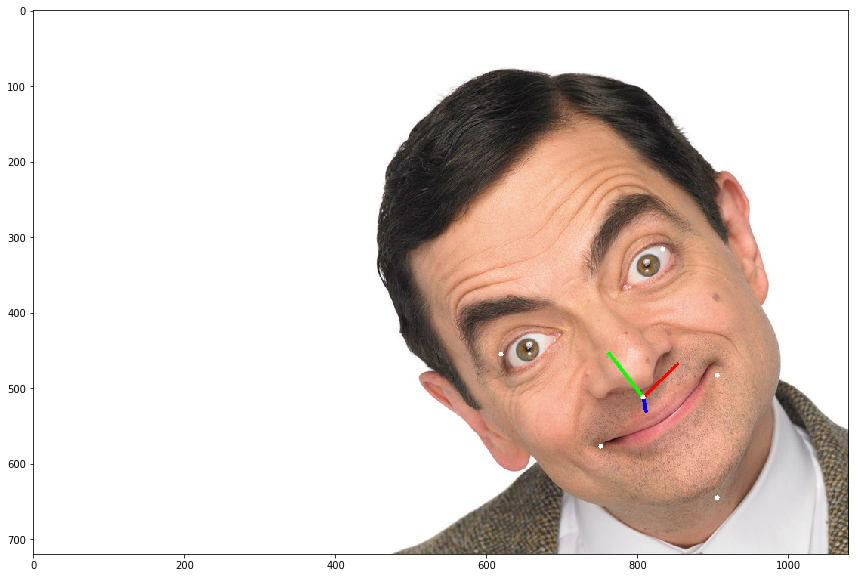

up(+)/down(-) [pitch]:  [ 12.57553758]
right(+)/left(-) [yaw]  :  [ 11.66559824]
right(+)/left(-) [roll] :  [ 34.92104608]


In [20]:
# project the 3D point (100.0, 0, 0) to 2D coordinate platform
(x_end_point2D, jacobian) = cv2.projectPoints(np.array([(100.0, 0.0, 0.0)]), rotation_vector
                                                 , translation_vector, camera_matrix, dist_coeffs)

# project the 3D point (0, 100.0, 0) to 2D coordinate platform
(y_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 100.0, 0.0)]), rotation_vector
                                                 , translation_vector, camera_matrix, dist_coeffs)

# project the 3D point (0, 0, 100.0)to 2D coordinate platform
(z_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 100.0)]), rotation_vector
                                           , translation_vector, camera_matrix, dist_coeffs)


# Taking the tip of the nose as the original, draw the x, y, z axis
p_nose = (int(face_points[0][0]), int(face_points[0][1]))

p_x = (int(x_end_point2D[0][0][0]), int(x_end_point2D[0][0][1]))

p_y = (int(y_end_point2D[0][0][0]), int(y_end_point2D[0][0][1]))

p_z = (int(z_end_point2D[0][0][0]), int(z_end_point2D[0][0][1]))

cv2.line(img, p_nose, p_x, (0,0,255), 3)  # X axis (red)
cv2.line(img, p_nose, p_y, (0,255,0), 3)  # Y axis (green)
cv2.line(img, p_nose, p_z, (255,0,0), 3)  # Z axis (blue)

# mark the 6 landmarks
for p in face_points:
    cv2.circle(img, (int(p[0]), int(p[1])), 3, (255,255,255), -1)

# show the image
plt.figure(figsize=(20,10))
plt.imshow(img[:,:,::-1]) # BGR to RGB
plt.show()

print("up(+)/down(-) [pitch]: ", pitch) # 抬頭(+)/低頭(-)
print("right(+)/left(-) [yaw]  : ", yaw)   # 右轉(+)/左轉(-)
print("right(+)/left(-) [roll] : ", roll)  # 右傾(+)/左傾(-)

### Show the all 68 landmarks for the detected face 

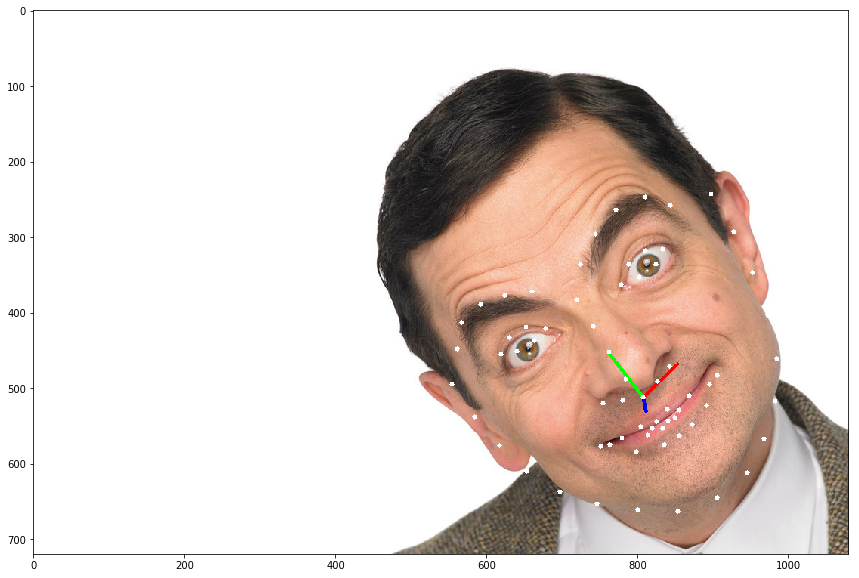

In [21]:
# mark the 68 landmarks
for p in landmarks:
    cv2.circle(img, (int(p[0]), int(p[1])), 3, (255,255,255), -1)

# show the image
plt.figure(figsize=(20,10))
plt.imshow(img[:,:,::-1]) # BGR to RGB
plt.show()

### Mark the parts of the detected face

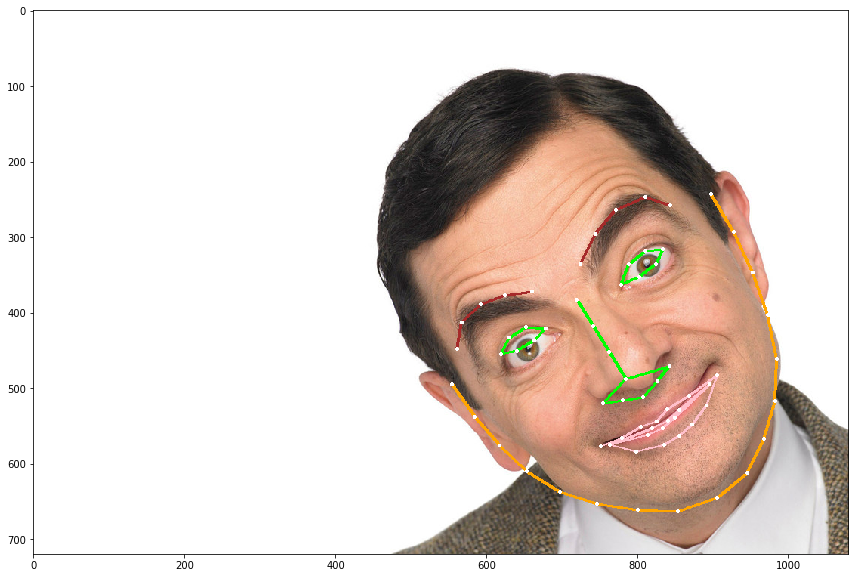

In [16]:
# using PIL
from PIL import Image, ImageDraw, ImageFont

# read the original image
image_copy = Image.open(TEST_IMAGE);
### mark the parts on image_copy###
# (Jaw: 17 points) 1 ~ 17
jaw = landmarks[0:17]

# (Left eyebrow: 5 points)  18 ~ 22
left_eyebrow = landmarks[17:22]

# (Right eyebrow: 5 points)  23 ~ 27
right_eyebrow = landmarks[22:27]

# (Nose: 9 points) 28 ~ 31 , 32 ~ 36
vertical_nose = landmarks[27:31]
horizontal_nose = landmarks[31:36]

# (Left eye: 6 points)  37 ~ 42
left_eye = landmarks[36:42]

# (Right eye: 6 points)  43 ~ 48
right_eye = landmarks[42:48]

# (Mouth: 20 points) 49 ~ 68
mouth = landmarks[48:68]

img_draw = ImageDraw.Draw(image_copy)
# mark Jaw (Jaw: 17 points) 1 ~ 17
img_draw.line(jaw.flatten().tolist(), fill='orange', width=4)
# mark Left Eyebrow (Left eyebrow: 5 points)  18 ~ 22
img_draw.line(left_eyebrow.flatten().tolist(), fill='brown', width=4)
# mark Right Eyebrow (Right eyebrow: 5 points)  23 ~ 27
img_draw.line(right_eyebrow.flatten().tolist(), fill='brown', width=4)
# mark Nose (Nose: 9 points) 28 ~ 31 , 32 ~ 36
img_draw.line(vertical_nose.flatten().tolist(), fill='#00FF00', width=4)
img_draw.line(horizontal_nose.flatten().tolist(), fill='#00FF00', width=4)
img_draw.line(np.take(landmarks,[30,31],0).flatten().tolist(), fill='#00FF00', width=4)
img_draw.line(np.take(landmarks,[30,35],0).flatten().tolist(), fill='#00FF00', width=4)
# mark Left Eye (Left eye: 6 points)  37 ~ 42
img_draw.line(np.take(landmarks,[36,37,38,39,40,41,36],0).flatten().tolist(), fill='#00FF00', width=4)
# mark Right Eye (Right eye: 6 points)  43 ~ 48
img_draw.line(np.take(landmarks,[42,43,44,45,46,47,42],0).flatten().tolist(), fill='#00FF00', width=4)
# mark Mouth (Mouth: 20 points) 49 ~ 68
img_draw.line(mouth.flatten().tolist(), fill='pink', width=3)
img_draw.line(np.take(landmarks,[60,67],0).flatten().tolist(), fill='pink', width=4)

### mark the all 68 facial landmarks
# we want to control the size of the marking circle
r = 2 # Radius of circle

# for each landmark (x,y)
for i in range(landmarks.shape[0]):
    (x,y) = landmarks[i,:]
    # count the 4 coordinates of the circle [(x1,y1),(x2,y2)]
    img_draw.ellipse((x-r,y-r, x+r, y+r), fill='white') 

plt.figure(figsize=(20,10))
plt.imshow(image_copy); plt.show()